# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

# plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [3]:
!pip install finance-datareader

In [88]:
import FinanceDataReader as fdr

In [89]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [90]:
stock = fdr.DataReader(STOCK_CODE, '1999-04-27', '2022-12-31')

In [91]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-12-23,58200,58400,57700,58100,9829407,-0.016920
2022-12-26,58000,58100,57700,57900,6756411,-0.003442
2022-12-27,58000,58400,57900,58100,10667027,0.003454
2022-12-28,57600,57600,56400,56600,14665410,-0.025818
2022-12-29,56000,56200,55300,55300,11295935,-0.022968


## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.02188261, 0.02102273, 0.02130726, 0.00334549, 0.01207878,
        0.38862858],
       [0.02122924, 0.02018595, 0.02132961, 0.00334549, 0.00673675,
        0.47838086],
       [0.02122924, 0.01980372, 0.02032402, 0.00217065, 0.0081894 ,
        0.28870118],
       ...,
       [0.78294574, 0.73347107, 0.77988827, 0.76391344, 0.15320126,
        0.41968954],
       [0.77408638, 0.72520661, 0.76536313, 0.75160561, 0.22243318,
        0.42365687],
       [0.76190476, 0.71384298, 0.76201117, 0.74601114, 0.13581178,
        0.45310862]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [63]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [66]:
x_train.shape, y_train.shape

((4799, 5), (4799,))

In [67]:
x_test.shape, y_test.shape

((1200, 5), (1200,))

In [68]:
x_train

,Open,High,Low,Volume,Change
0,0.021883,0.021023,0.021307,0.012079,0.388629
1,0.021229,0.020186,0.021330,0.006737,0.478381
2,0.021229,0.019804,0.020324,0.008189,0.288701
3,0.020122,0.018771,0.019631,0.012499,0.417239
4,0.019911,0.018595,0.019777,0.004826,0.472546
...,...,...,...,...,...
4794,0.504430,0.473140,0.501676,0.089954,0.425290
4795,0.497785,0.474174,0.499441,0.110591,0.505338
4796,0.509413,0.477273,0.510615,0.103730,0.528059
4797,0.518826,0.491736,0.518436,0.149901,0.561267


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [69]:
import tensorflow as tf

In [70]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [71]:
WINDOW_SIZE=35
BATCH_SIZE=32

In [72]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [73]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 35, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [75]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [76]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [77]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    145/Unknown - 4s 8ms/step - loss: 1.2404e-04 - mse: 2.4808e-04
Epoch 1: val_loss improved from inf to 0.00248, saving model to tmp/ckeckpointer.ckpt
149/149 [==============================] - 5s 13ms/step - loss: 1.2325e-04 - mse: 2.4649e-04 - val_loss: 0.0025 - val_mse: 0.0050
Epoch 2/50
147/149 [============================>.] - ETA: 0s - loss: 4.7130e-05 - mse: 9.4260e-05
Epoch 2: val_loss improved from 0.00248 to 0.00115, saving model to tmp/ckeckpointer.ckpt
149/149 [==============================] - 2s 12ms/step - loss: 4.7972e-05 - mse: 9.5943e-05 - val_loss: 0.0011 - val_mse: 0.0023
Epoch 3/50
144/149 [===========================>..] - ETA: 0s - loss: 4.2010e-05 - mse: 8.4019e-05
Epoch 3: val_loss improved from 0.00115 to 0.00104, saving model to tmp/ckeckpointer.ckpt
149/149 [==============================] - 2s 11ms/step - loss: 4.4189e-05 - mse: 8.8379e-05 - val_loss: 0.0010 - val_mse: 0.0021
Epoch 4/50
140/149 [===========================>..] - ETA: 0s - loss

저장한 ModelCheckpoint 를 로드합니다.

In [81]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [82]:
pred = model.predict(test_data)

37/37 [==============================] - 0s 6ms/step


In [83]:
pred.shape

(1165, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

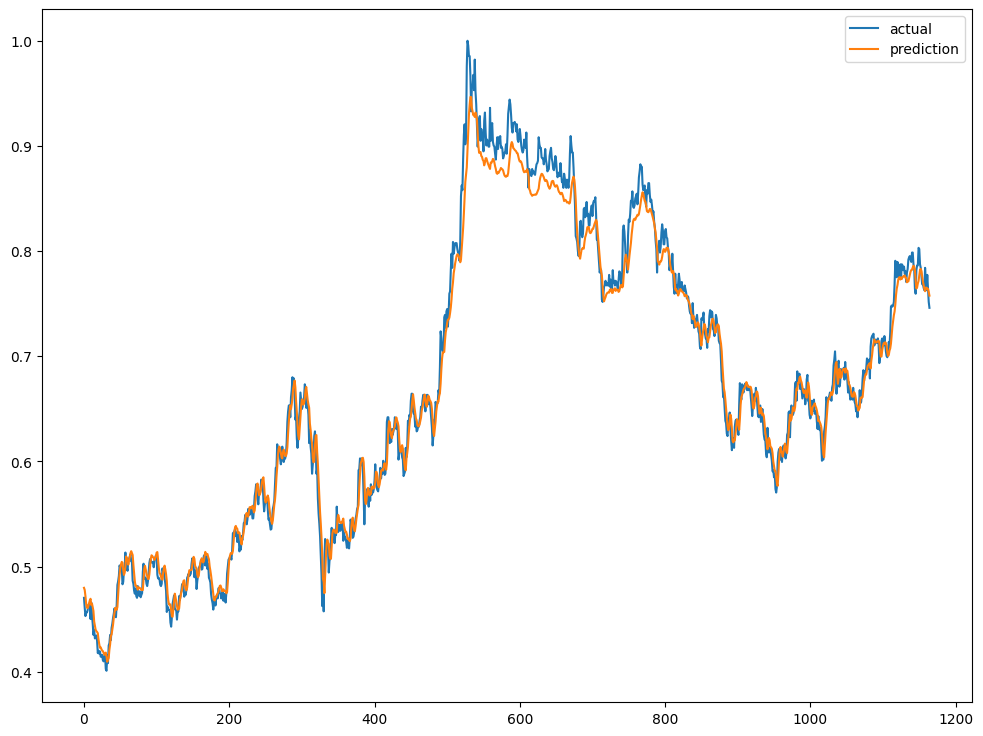

In [84]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[35:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [104]:
# 2023년 1월 1일을 예측하기 위한 마지막 35일의 데이터를 가져옵니다.
last_35_days = fdr.DataReader(STOCK_CODE, '1999-04-27', '2022-12-31')

# 스케일링을 적용합니다.
scaled_last_35_days = scaler.transform(last_35_days[scale_cols])

# 데이터프레임으로 만듭니다.
df_last_35_days = pd.DataFrame(scaled_last_35_days, columns=scale_cols)

# 종가를 제외한 데이터를 만듭니다.
data_for_prediction = df_last_35_days.drop('Close', axis=1)

def windowed_inputs(series, window_size):
    series = np.array(series).reshape(-1, 1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(1)
    return ds

def predict_future(data, window_size, model):
    future_pred_dataset = windowed_inputs(data, window_size)
    future_pred = model.predict(future_pred_dataset)
    return future_pred[-1][0]

last_35_days_scaled_close = df_last_35_days['Close']

# 2023년 1월 1일 종가 예측
predicted_close = predict_future(last_35_days_scaled_close, WINDOW_SIZE, model)

unscaled_prediction = scaler.inverse_transform(np.array([[0, 0, 0, predicted_close, 0, 0]]))
predicted_close_price = unscaled_prediction[0][3]

print(f"2023년 1월 1일의 종가 예측: {predicted_close_price:.2f}")

   2974/Unknown - 8s 3ms/step

KeyboardInterrupt: ignored

In [109]:
def predict_daily_close(df, start_date, end_date, window_size, model, scaler):
    daily_predictions = {}

    # 존재하는 날짜만 선택
    trading_days = [d for d in pd.date_range(start_date, end_date, closed='right') if d in df.index]

    for target_date in trading_days:
        last_35_days = df.loc[:target_date - pd.Timedelta(days=1)].tail(window_size)
        last_35_days_scaled = scaler.transform(last_35_days)

        predicted_close = predict_future(last_35_days_scaled[:, 3], window_size, model)
        new_row = np.copy(last_35_days_scaled[-1])
        new_row[3] = predicted_close
        unscaled_prediction = scaler.inverse_transform(np.array([new_row]))[:, 3][0]

        daily_predictions[target_date] = unscaled_prediction

    return daily_predictions



# 데이터 로드
df = fdr.DataReader(STOCK_CODE, '1999-04-27', '2023-08-04')

# 예측 실행
start_date = '2023-01-01'
end_date = '2023-08-04'
daily_predictions = predict_daily_close(df, start_date, end_date, WINDOW_SIZE, model, scaler)

# 종가 출력
print_daily_close_predictions(daily_predictions)

1/1 [==============================] - 0s 48ms/step
2023-01-02: 56553.59326314926
2023-01-03: 55840.5335534811
2023-01-04: 55598.08099985123
2023-01-05: 56713.44371855259
2023-01-06: 57658.25382685661
2023-01-09: 58525.27754032612
2023-01-10: 59482.105598688126
2023-01-11: 60195.6980189085
2023-01-12: 60575.18503499031
2023-01-13: 60568.19054543972
2023-01-16: 60730.29436647892
2023-01-17: 60983.08150482178
2023-01-18: 61125.84260571003
2023-01-19: 60898.53501307964
2023-01-20: 61139.394762158394
2023-01-25: 61476.95745778084
2023-01-26: 62262.08757805824
2023-01-27: 62910.73725485802
2023-01-30: 63568.25656235218
2023-01-31: 63703.186818122864
2023-02-01: 62528.133882045746
2023-02-02: 61837.954090595245
2023-02-03: 62322.89116048813
2023-02-06: 63121.18455851078
2023-02-07: 62892.85948872566
2023-02-08: 62347.395845890045
2023-02-09: 62438.99009823799
2023-02-10: 62865.733867406845
2023-02-13: 63086.57968103886
2023-02-14: 63021.67955446243
2023-02-15: 63114.200723171234
2023-02-16: 

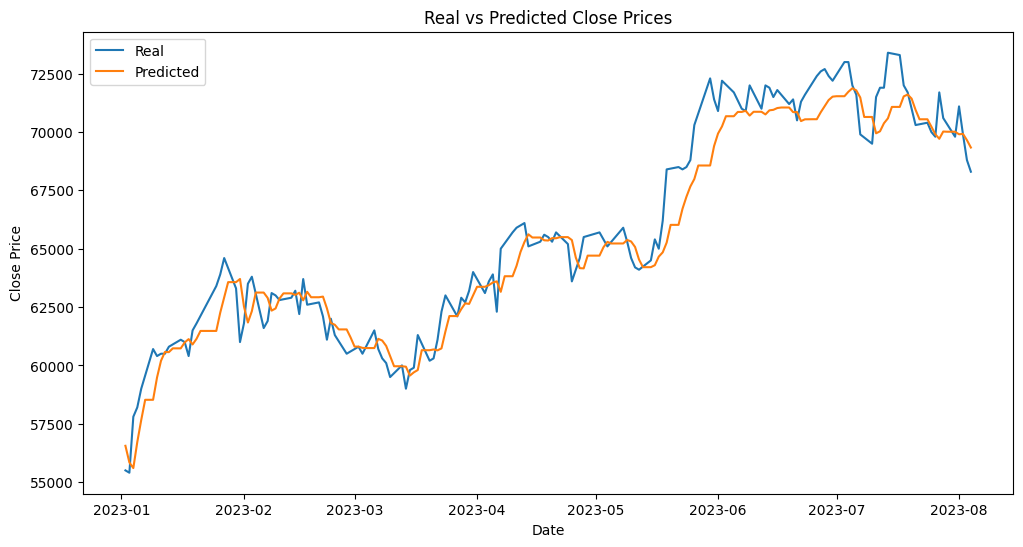

In [108]:
import matplotlib.pyplot as plt

real_df = fdr.DataReader(STOCK_CODE, '2023-01-01', '2023-08-04')
real_closes = real_df['Close']


def plot_real_vs_predicted(real_closes, predicted_closes):
    plt.figure(figsize=(12, 6))
    plt.plot(real_closes.index, real_closes.values, label="Real")
    plt.plot(pd.to_datetime(list(predicted_closes.keys())), list(predicted_closes.values()), label="Predicted")

    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Real vs Predicted Close Prices')
    plt.legend()
    plt.show()

plot_real_vs_predicted(real_closes, daily_predictions)